###Q1. Load and Inspect Dataset

In [135]:
from sklearn.datasets import fetch_openml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
import time

In [136]:
dataset = fetch_openml(data_id=43463, as_frame=True)
df = dataset.frame.copy()

print("Dataset shape:", df.shape)
print("\nCoulumns:", df.columns)
print("\nMissing values per column:", df.isnull().sum())
print("\nDuplicated rows:", df.duplicated().sum())

if df.duplicated().sum() > 0:
    print(df[df.duplicated()].head())

Dataset shape: (1338, 7)

Coulumns: Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

Missing values per column: age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Duplicated rows: 1
     age   sex    bmi  children smoker     region    charges
581   19  male  30.59         0     no  northwest  1639.5631


###Q2. Dataset Splitting

In [137]:
target_col = 'charges'
X_raw = df.drop(columns=[target_col])
y_raw = df[target_col].astype(float).values.reshape(-1, 1)
X_train, X_test_val, y_train, y_test_val = train_test_split(X_raw, y_raw, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)

In [138]:
numeric_cols = X_raw.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_raw.select_dtypes(exclude=[np.number]).columns.tolist()

###Q3. Feature Preprocessing

In [139]:
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numeric_cols])
X_val_num = scaler.transform(X_val[numeric_cols])
X_test_num = scaler.transform(X_test[numeric_cols])
# Scale target
y_scaler = StandardScaler()
y_train_proc = y_scaler.fit_transform(y_train.reshape(-1,1)).ravel()
y_val_proc   = y_scaler.transform(y_val.reshape(-1,1)).ravel()
y_test_proc  = y_scaler.transform(y_test.reshape(-1,1)).ravel()


In [140]:
if len(cat_cols) > 0:
  encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
  X_train_cat = encoder.fit_transform(X_train[cat_cols])
  X_val_cat = encoder.transform(X_val[cat_cols])
  X_test_cat = encoder.transform(X_test[cat_cols])

  X_train_proc = np.hstack((X_train_num, X_train_cat))
  X_val_proc = np.hstack((X_val_num, X_val_cat))
  X_test_proc = np.hstack((X_test_num, X_test_cat))

else:
  X_train_proc = X_train_num
  X_val_proc = X_val_num
  X_test_proc = X_test_num

In [141]:
y_train = y_train.ravel()
y_val = y_val.ravel()
y_test = y_test.ravel()

###Q4. Implement Feedforward Neural Network

In [142]:
import numpy as np

class FeedForwardNN:
    def __init__(self, input_dim, hidden_layers=[32, 32], lr=0.001, seed=42):
        np.random.seed(seed)
        self.lr = lr
        self.L = len(hidden_layers) + 1   # hidden + output layer

        # Layer sizes: input → hidden layers → output
        layer_dims = [input_dim] + hidden_layers + [1]

        # Initialize weights and biases
        self.weights = []
        self.biases = []
        for i in range(len(layer_dims) - 1):
            W = np.random.randn(layer_dims[i], layer_dims[i+1]) * np.sqrt(2. / layer_dims[i])
            b = np.zeros((1, layer_dims[i+1]))
            self.weights.append(W)
            self.biases.append(b)

    def forward(self, X):
        self.a = [X]  # store activations, a[0] = input
        out = X
        for i, (W, b) in enumerate(zip(self.weights, self.biases)):
            z = out @ W + b
            if i == len(self.weights) - 1:  # output layer (regression)
                out = z
            else:  # hidden layer
                out = np.tanh(z)
            self.a.append(out)
        return out

    def backward(self, y_true):
      y_true = y_true.reshape(-1, 1)
      yhat = self.a[-1] #predictions
      n = y_true.shape[0]

      loss = np.mean((yhat - y_true) ** 2)

      delta = (2.0 / n) * (yhat - y_true)

      for i in reversed(range(self.L)): #backpropagation loop
          a_prev = self.a[i]
          dW = a_prev.T @ delta
          db = delta.sum(axis=0, keepdims=True) # gradient of weights and biases

          self.weights[i] -= self.lr * dW
          self.biases[i]  -= self.lr * db

          if i > 0:
              delta = (delta @ self.weights[i].T) * (1 - self.a[i]**2)

      return loss

    def fit(self, X, y, X_val=None,y_val = None, epochs=100, batch_size=32):
      n = X.shape[0]
      history = {"train_loss": [], "val_loss": []}

      for epoch in range(epochs): #shuffle training data
        indices = np.random.permutation(n)
        X, y = X[indices], y[indices]

        for i in range(0, n, batch_size): #mini-batch training
          X_batch, y_batch = X[i:i+batch_size], y[i:i+batch_size]
          self.forward(X_batch)
          self.backward(y_batch)

        train_loss = np.mean((self.predict(X) - y) ** 2)

        if X_val is not None:
          val_loss = np.mean((self.predict(X_val) - y_val) ** 2)
          history["val_loss"].append(val_loss)

        if epoch % 10 == 0 :
          if X_val is not None:
            print(f"Epoch {epoch}/{epochs} : Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
          else:
            print(f"Epoch {epoch}/{epochs} : Train Loss: {train_loss:.4f}")

      return history

    def predict(self, X):
        return self.forward(X).ravel()


In [143]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=50, batch_size=32):
    n = X_train.shape[0] # number of training examples
    train_losses = [] # store training loss history
    val_losses = [] # store validation loss history
    for ep in range(epochs):

        perm = np.random.permutation(n)
        Xs = X_train[perm]
        ys = y_train[perm]

        epoch_loss = 0.0 # accumulate loss over mini-batches
        for i in range(0, n, batch_size):
            xb = Xs[i:i+batch_size] # batch features
            yb = ys[i:i+batch_size] # batch labels
            model.forward(xb)
            batch_loss = model.backward(yb) # backpropagation and parameter update
            epoch_loss += batch_loss * xb.shape[0]
        epoch_loss /= n

        yval_pred = model.predict(X_val)
        val_loss = mean_squared_error(y_val, yval_pred)
        train_losses.append(epoch_loss)
        val_losses.append(val_loss)

        if (ep+1) % max(1, epochs//10) == 0 or ep == 0:
            print(f"Epoch {ep+1}/{epochs} - Train MSE: {epoch_loss:.6f}, Val MSE: {val_loss:.6f}")
    return train_losses, val_losses

###Q5. Hyperparameter Tuning

In [144]:
neurons_list = [32, 64, 128] # candidate neurons
hidden_layer_counts = [2, 3] # candidate number of layers
best_config = None
best_val = float("inf")
best_history = None
best_model = None
lr = 1e-3
batch_size = 32
epochs = 80

print("\nStarting hyperparameter tuning:")
for n in neurons_list:
    for nlayers in hidden_layer_counts:
        hidden_layers = [n] * nlayers
        print(f"\nTraining config hidden_layers={hidden_layers}, lr={lr}, batch_size={batch_size}")
        model = FeedForwardNN(input_dim=X_train_proc.shape[1], hidden_layers=hidden_layers, lr=lr, seed=1)
        start = time.time()
        # train model on current configuration
        train_losses, val_losses = train_model(model, X_train_proc, y_train_proc, X_val_proc, y_val_proc, epochs=epochs, batch_size=batch_size)
        dur = time.time() - start
        final_val = val_losses[-1]
        best_epoch = np.argmin(val_losses) + 1 # epoch index of minimum val loss
        best_val_epoch = min(val_losses)

        print(f"Config {hidden_layers} finished in {dur:.1f}s.")
        print(f"  Final val MSE={final_val:.6f}, Best epoch {best_epoch} val MSE={best_val_epoch:.6f}")
        if best_val_epoch < best_val:
            best_val = best_val_epoch
            best_config = (hidden_layers, lr, batch_size)
            best_history = (train_losses, val_losses)
            best_model = model
# final report of the best config
print("\nBest hyperparameters:", best_config, "with val MSE:", best_val)


Starting hyperparameter tuning:

Training config hidden_layers=[32, 32], lr=0.001, batch_size=32
Epoch 1/80 - Train MSE: 1.218771, Val MSE: 1.083671
Epoch 8/80 - Train MSE: 0.412219, Val MSE: 0.438182
Epoch 16/80 - Train MSE: 0.311938, Val MSE: 0.345542
Epoch 24/80 - Train MSE: 0.292558, Val MSE: 0.325436
Epoch 32/80 - Train MSE: 0.282391, Val MSE: 0.313592
Epoch 40/80 - Train MSE: 0.274039, Val MSE: 0.303136
Epoch 48/80 - Train MSE: 0.266372, Val MSE: 0.294247
Epoch 56/80 - Train MSE: 0.259616, Val MSE: 0.285567
Epoch 64/80 - Train MSE: 0.253018, Val MSE: 0.278310
Epoch 72/80 - Train MSE: 0.247221, Val MSE: 0.271773
Epoch 80/80 - Train MSE: 0.241650, Val MSE: 0.265332
Config [32, 32] finished in 0.8s.
  Final val MSE=0.265332, Best epoch 80 val MSE=0.265332

Training config hidden_layers=[32, 32, 32], lr=0.001, batch_size=32
Epoch 1/80 - Train MSE: 0.810489, Val MSE: 0.729972
Epoch 8/80 - Train MSE: 0.379881, Val MSE: 0.410325
Epoch 16/80 - Train MSE: 0.312565, Val MSE: 0.347231
Epoc

###Q6. Training & Validation Curves

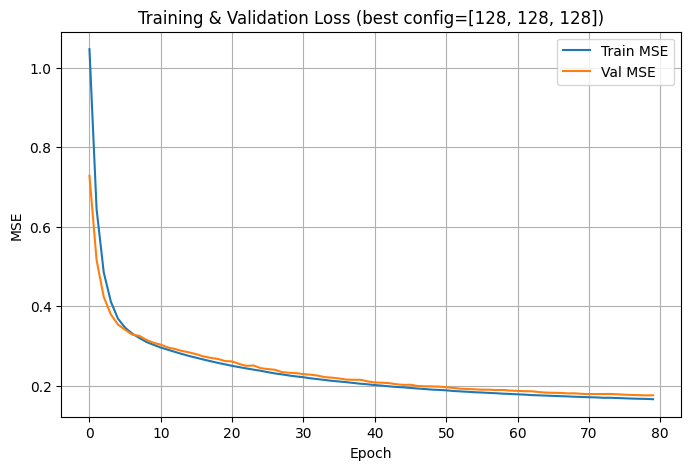

In [145]:
train_losses, val_losses = best_history
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train MSE')
plt.plot(val_losses, label='Val MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title(f'Training & Validation Loss (best config={best_config[0]})')
plt.legend()
plt.grid(True)
plt.show()

###Q7. Model Evaluation – Custom NN

In [146]:
y_test_pred_scaled = best_model.predict(X_test_proc).reshape(-1, 1)
y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled)
y_test_pred_rounded = np.rint(y_test_pred).ravel()

mse_test = mean_squared_error(y_test, y_test_pred_rounded)
r2_test = r2_score(y_test, y_test_pred_rounded)
print("\nCustom NN Test performance (rounded preds):")
print("MSE:", mse_test)
print("R2:", r2_test)


Custom NN Test performance (rounded preds):
MSE: 22140731.339936364
R2: 0.8430539341074699


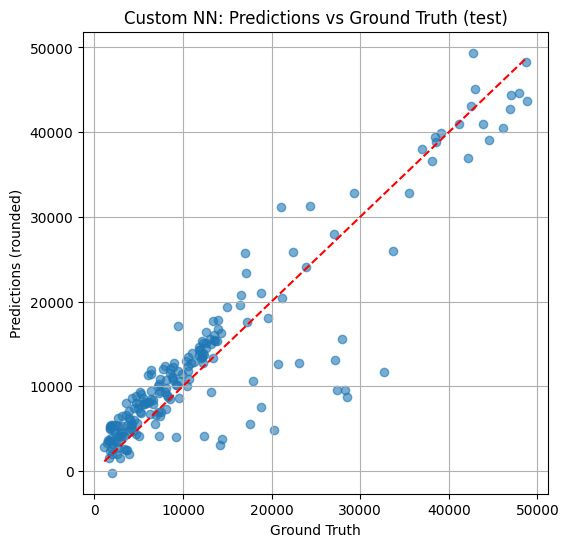

In [147]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred_rounded, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Ground Truth')
plt.ylabel('Predictions (rounded)')
plt.title('Custom NN: Predictions vs Ground Truth (test)')
plt.grid(True)
plt.show()

###Q8. Sklearn MLPRegressor


Training sklearn MLPRegressor with hidden_layers= (128, 128, 128)


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Sklearn MLPRegressor Test performance (rounded preds):
MSE: 19875387.02489059
R2: 0.8591119799181401


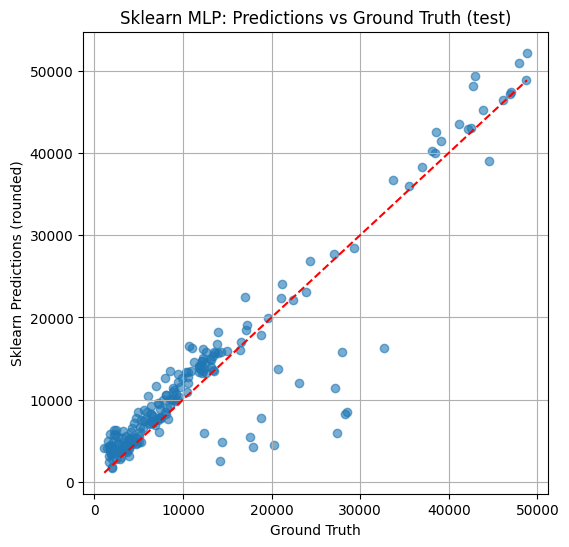

In [148]:
hidden_layers = tuple(best_config[0])
print("\nTraining sklearn MLPRegressor with hidden_layers=", hidden_layers)
# using scikitlearn's MLP regressor
mlp = MLPRegressor(hidden_layer_sizes=hidden_layers, activation='relu', solver='adam',
                   learning_rate_init=best_config[1], batch_size=best_config[2], max_iter=500, random_state=1)

mlp.fit(X_train_proc, y_train)
y_test_sk = mlp.predict(X_test_proc)
y_test_sk_rounded = np.rint(y_test_sk)

mse_sk = mean_squared_error(y_test, y_test_sk_rounded)
r2_sk = r2_score(y_test, y_test_sk_rounded)

print("\nSklearn MLPRegressor Test performance (rounded preds):")
print("MSE:", mse_sk)
print("R2:", r2_sk)

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_sk_rounded, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Ground Truth')
plt.ylabel('Sklearn Predictions (rounded)')
plt.title('Sklearn MLP: Predictions vs Ground Truth (test)')
plt.grid(True)
plt.show()

## Comparing values of both models to verify credibility of the custom regressor

In [149]:
print("\nComparison (rounded predictions):")
print(f"Custom NN    -> MSE: {mse_test:.6f}, R2: {r2_test:.6f}")
print(f"Sklearn MLP  -> MSE: {mse_sk:.6f}, R2: {r2_sk:.6f}")


Comparison (rounded predictions):
Custom NN    -> MSE: 22140731.339936, R2: 0.843054
Sklearn MLP  -> MSE: 19875387.024891, R2: 0.859112
